In [ ]:
!apt-get --yes install make cmake build-essential libboost-all-dev

In [ ]:
!pip install protobuf tqdm wheel

In [ ]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [ ]:
cd bigartm

In [ ]:
mkdir build

In [ ]:
cd build

In [ ]:
!cmake ..

In [ ]:
!make

In [ ]:
!pip install python/bigartm*.whl -U

Вернемся в изначальную папку.

In [ ]:
cd ../.. 

In [ ]:
!pip install matplotlib

# Домашнее задание


Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

## Data

In [13]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [14]:
nltk.download('punkt');nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

class FasterMorph:
    
    def __init__(self):
        self.morph = MorphAnalyzer()
        self.__cache = {}
    
    def analyze(self, word):
        if word not in self.__cache:
            self.__cache[word] = self.morph.parse(word)[0].normal_form
        return self.__cache[word]
        

        
def opt_normalize(texts, top=None):
    analyzer = FasterMorph()
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    d = pd.DataFrame(uniq.most_common(top))
    unique = d[(d[1] > d[1].quantile(0.2)) & (d[1] < d[1].quantile(0.8))][0].tolist()
    norm_uniq = {word:analyzer.analyze(word) for word in unique}
    
    norm_texts = []
    for text in texts:
        norm_words = [norm_uniq.get(word) for word in text if norm_uniq.get(word)]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    return words

In [37]:
with open('habr_texts.txt') as file:
    texts = file.read().splitlines()

In [38]:
texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in texts], 20000)

In [41]:
phrases = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian')))
phraser = gensim.models.phrases.Phraser(phrases)
ngrammed_habr_texts = phraser[texts]

In [ ]:
def write_vw(texts, file_name):
    with open(filename, 'w') as file:
        for i, text in enumerate(ngrammed_habr_texts):
            unique_words = Counter(text)
            doc = f'doc_{i} ' 
            vw_text = ' '.join([f'{word}:{str(unique_words[word])}' for word in unique_words])
            file.write(f'{doc}{vw_text}\n')

In [ ]:
write_vw(texts, 'habr_texts.vw')
write_vw(ngrammed_habr_texts, 'habr_texts_ngram.vw')

## Metrics

In [43]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

## Batching

In [45]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',
                                        data_format='vowpal_wabbit',
                                        target_folder='batches',
                                       batch_size=5000)

In [47]:
dictionary = artm.Dictionary()

In [48]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class')

artm.Dictionary(name=d6125c22-f8cd-4bef-abfd-43e468696d1d, num_entries=9350)

In [49]:
dictionary.save_text('dict.txt')

## Model compilation

In [50]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [51]:
model_artm.initialize(dictionary=dictionary, )

In [52]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

## Model Training

In [53]:
model_artm.num_document_passes = 3
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.014 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 2365.723 (ARTM)


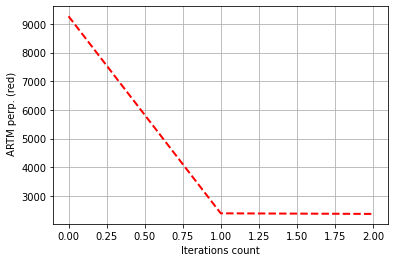

In [54]:
print_measures(model_artm)

Perplexity score of 2365.723 does not fit into the recommended range (from 200 to 1000)

## Adding regulirisers

In [55]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [56]:
model_artm.fit_offline(batch_vectorizer = batch_vectorizer,num_collection_passes=1)

## Incrementing the tau's

In [57]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.788 ARTM)
Sparsity Theta: 0.200 (ARTM)
Kernel contrast: 0.278 (ARTM)
Kernel purity: 0.257 (ARTM)
Perplexity: 1080.190 (ARTM)


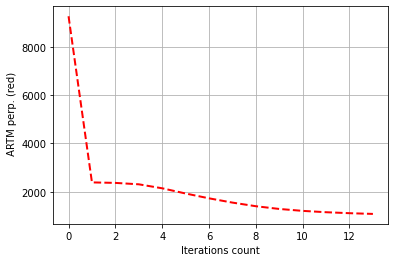

In [58]:
print_measures(model_artm)

This experiment showed a great decrease of the perplexity score. This fact perfectly illustrates the viability of gradual regularisation parameter tau change.

In [80]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    except KeyError:
        continue

topic_0: 
это
весь
кат
поезд
который
хабра
работа
самый
менять
последний
---------
topic_1: 
intel
ноутбук
компьютер
память
процессор
usb
lenovo
гб
клавиатура
устройство
---------
topic_2: 
поиск
социальный
ресурс
человек
сообщество
лицо
который
свой
информация
группа
---------
topic_3: 
оператор
связь
звонок
который
разговор
весь
мочь
номер
ценность
услуга
---------
topic_4: 
время
это
результат
который
весь
иметь
процесс
задача
мочь
использовать
---------
topic_5: 
это
весь
который
мочь
большой
свой
наш
должный
ещё
процесс
---------
topic_6: 
фильм
рейтинг
который
это
хороший
свой
время
просмотр
весь
ещё
---------
topic_7: 
команда
заказчик
проект
задача
разработчик
разработка
это
должный
тз
весь
---------
topic_8: 
значение
канал
переменный
поль
пол
кнопка
событие
текущий
выбрать
состояние
---------
topic_9: 
модель
слой
обучение
сеть
дать
алгоритм
признак
нейрон
параметр
значение
---------
topic_10: 
регистр
инструкция
mov
это
адрес
стек
eax
s
ptr
call
---------
topic_11: 
пользова

# Run 2

In this run we will be using ngrammed texts

In [63]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts_ngram.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=5000) # размер батча, подбирайте под свою память

In [65]:
dictionary = artm.Dictionary()

In [66]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class')

artm.Dictionary(name=e7be806c-2388-4db2-b637-144a319f25c5, num_entries=26215)

In [67]:
dictionary.save_text('dict_ngram.txt')

In [68]:
model_artm_ngram = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [69]:
model_artm_ngram.initialize(dictionary=dictionary)

In [70]:
model_artm_ngram.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm_ngram.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm_ngram.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm_ngram.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm_ngram.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

In [71]:
model_artm_ngram.num_document_passes = 3
model_artm_ngram.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.007 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 3362.435 (ARTM)


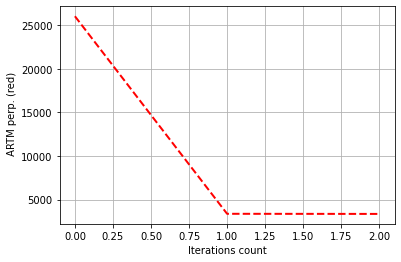

In [73]:
print_measures(model_artm_ngram)

Using ngrammed texts caused perplexity to rise

In [74]:
model_artm_ngram.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm_ngram.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [75]:
model_artm_ngram.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [77]:
phi_tau = model_artm_ngram.regularizers['SparsePhi'].tau
theta_tau = model_artm_ngram.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm_ngram.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.7))
    model_artm_ngram.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.3))
    model_artm_ngram.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.926 ARTM)
Sparsity Theta: 0.241 (ARTM)
Kernel contrast: 0.357 (ARTM)
Kernel purity: 0.261 (ARTM)
Perplexity: 1448.140 (ARTM)


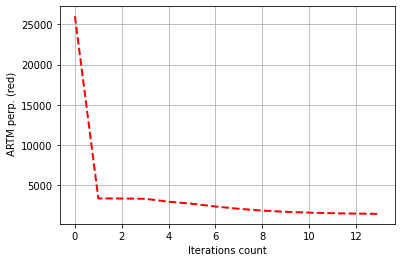

In [78]:
print_measures(model_artm_ngram)

After increasing phi_tau by 0.2 and theta_tau by 0.1 and using ngramms, we can witness an increase in perplexity by ~400 in comparison to previous regularized run

Best topics were found by the word-level model with SmoothSparsePhiRegularizer(tau=-0.15) and SmoothSparseThetaRegularizer(tau=-0.15). The model passed each document 3 times and the whole collection also 3 times. During training Phi_tau was increased by half of the current value, while Theta_tau by 0.1.

Верстка: 
    элемент
    стиль
    помощь
    это
    весь
    css
    color
    кнопка
    свойство
    блок
    
Assembler: 
регистр
инструкция
mov
это
адрес
стек
eax
s
ptr
call

UX: 
пользователь
дать
который
каждый
интерфейс
весь
задача
приложение
новый
архитектура